# uSEIR model Kalman Filter And Smoother

Test that the KF in useir model works

version: 2020/06/02
author : H.A. hernando


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Jun  4 16:44:26 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
import c19.useir            as us
import c19.kfilter          as kf

import scipy          as sp
import scipy.stats    as stats

from numpy.linalg import inv
m_   = np.matmul
npa  = np.array

## uSEIR

Generate a useir model with a $N$ population

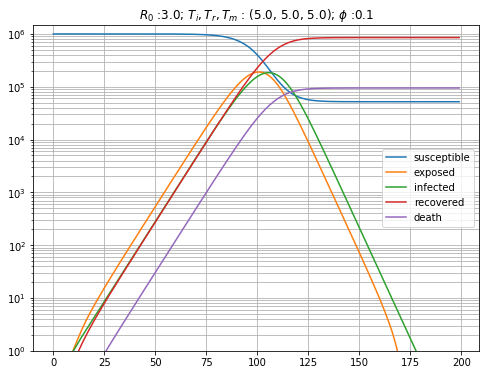

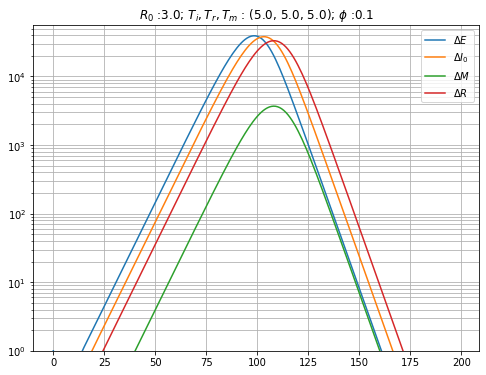

In [5]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 5.
PhiM            = 0.1
ndays           = 200
rho             = 'gamma'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

### generate data

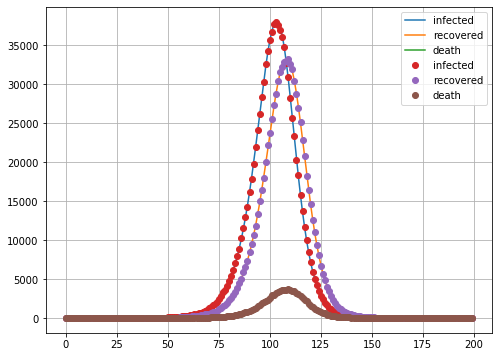

In [6]:
DS = DI0, DR, DM
ds = us.useir_rvdata(DI0, DR, DM)
us.plt_useir_rvdata(ts, DS, ds);

## KF - $\beta$

$$
\Delta I (t) = r (t)\; I(t') \circ \rho_i(t-t'| t'_i)   \\
\Delta R (t) = \phi_r \; \Delta I(t') \circ \rho_r(t-t' | t_r) \\
\Delta M (t) = \phi_m \; \Delta I(t') \circ \rho_m(t-t' | t_m) \\
$$

The state 
$$
(r(t), \phi_r, \phi_m)
$$
The measurement
$$
(\Delta i, \Delta r, \Delta m)
$$

The $H$-matrix


$$
H_{i} = \begin{pmatrix} I(t') \circ \rho_i(t-t'| t'_i)  & 0  &   0 \\
0  &  \Delta I(t') \circ \rho_r(t - t' | t_r)  &   0 \\
0  &  0 &  \Delta I(t') \circ \rho_m(t-t' | t_m)
\end{pmatrix}
$$






### measurements

Measurements are (di0, dr, dm) per day
- *di0*: number of new infections
- *dr* : number of new recovered
- *dm* : number of new deaths

errors are considered as poisson $\sqrt{n}$

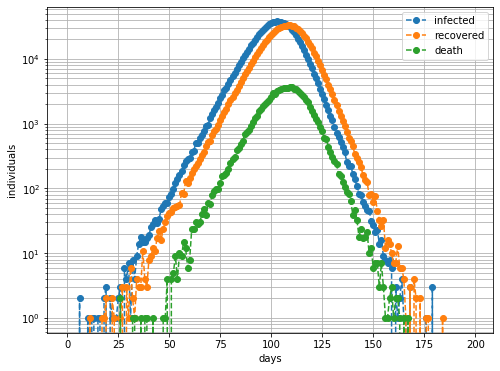

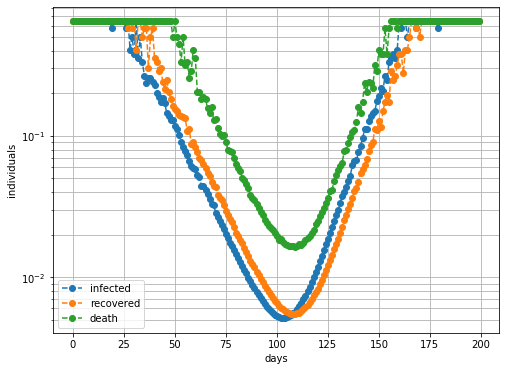

In [7]:
dios, drs, dms = ds
ms, ums        = us.kfmeas(ds)
us.plt_meas(ts, ms, ums)

### h matrices - with susceptible

h-matrices are in this model diagonal, they correspond to the prediction of new infected, new recovered and new deaths using previous infections and times of infection, recovery and death

if we include the fraction of susceptibles in the prediction, we can estimate global $\beta$.

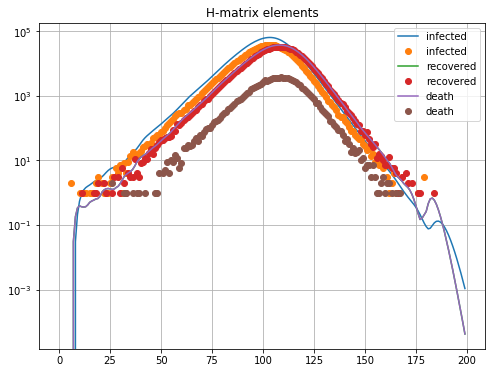

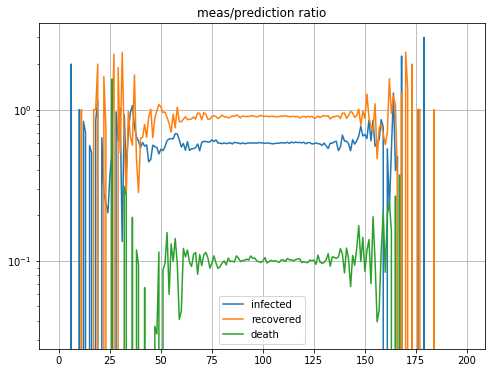

In [8]:
times = TI, TR, TM
hs   = us.kfhmatrices(ts, dios, times, sis = S/N)
us.plt_hmatrices2(ts, hs, ms);

### KF - with susceptibles

F are just indentity, and Q provides the increased error in each step.

In this case, using susceptible as inputs, errors can be null.

In [9]:
times    = TI, TR, TM
xss, xms = us.useir_kfs(ds, times, q0 = 0., sis = S/N, scale = False)

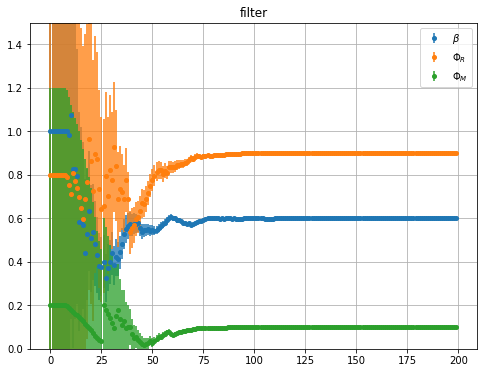

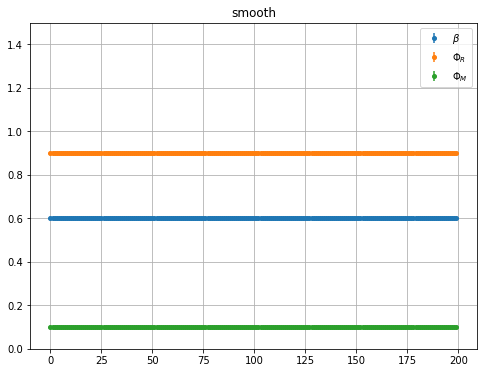

In [10]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5));

**Note**: Internally the KF uses kfstep, there are two derivation of the step, using the gain matrix $K$ (kf._kfstep_k) or weighting the measurment and the state (us._kfstep_m). Both provide goor results with q0 = 0 and S/N inputs

## KF  $\beta$(t) - rate evolution


### h matrices without susceptibles

Follow the infection rate, $\beta$(t), evolution. That is: do we not know the susceptible individuals at each time, $t$.

Test the back-propagation

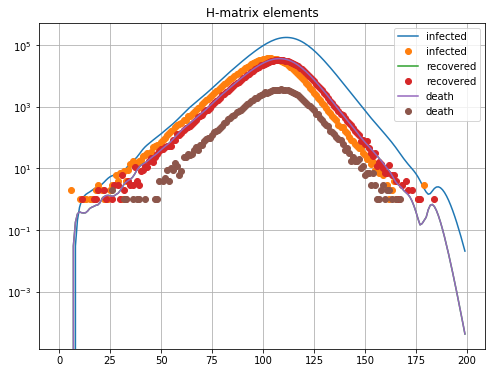

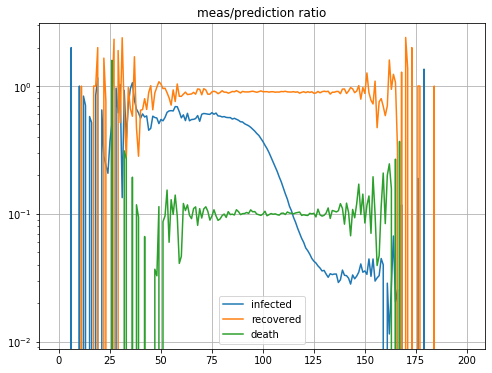

In [11]:
hs  = us.kfhmatrices(ts, dios, times)
us.plt_hmatrices2(ts, hs, ms);

### KF without susceptibles

In [12]:
times    = TI, TR, TM
q0       = np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0, scale = False)

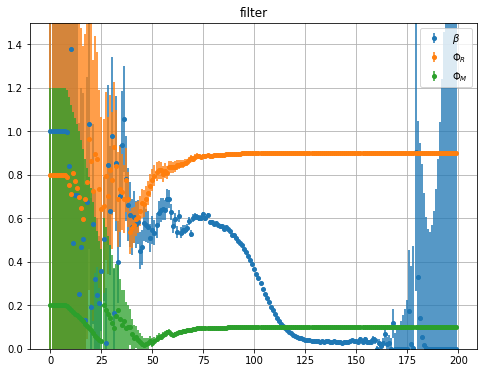

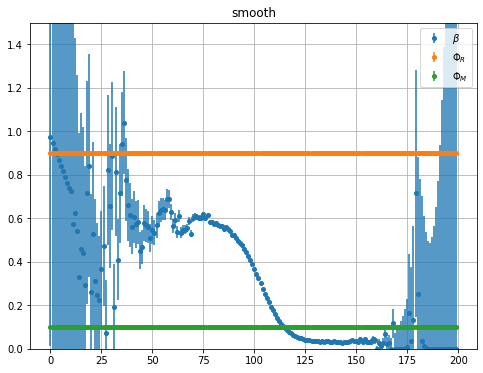

In [13]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5));

#### check that $\beta$(t) follows suceptibles

Check that $\beta(t) = R_0/T_R S(t)/N$, there is a delay $T_I$

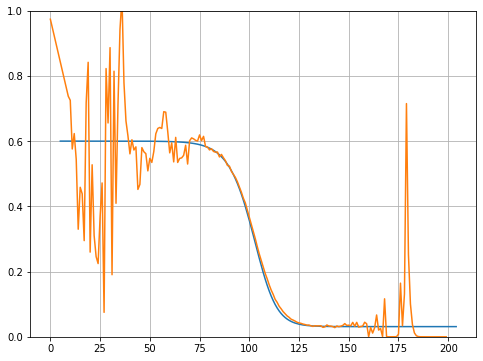

In [14]:
betas = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts + TI, R0/TR * S/N)
plt.plot(ts, betas);
plt.grid(); plt.ylim((0., 1.));

## Normalized inputs

In [15]:
times    = TI, TR, TM
q0       = 1e0 * np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0 = q0, scale = True)

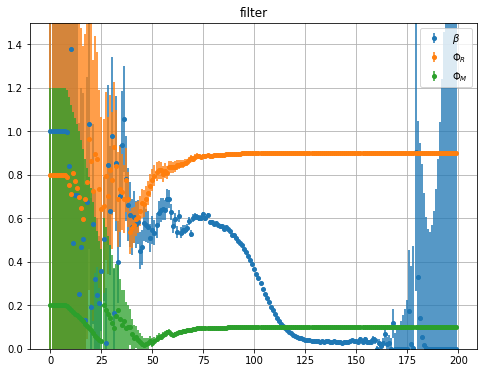

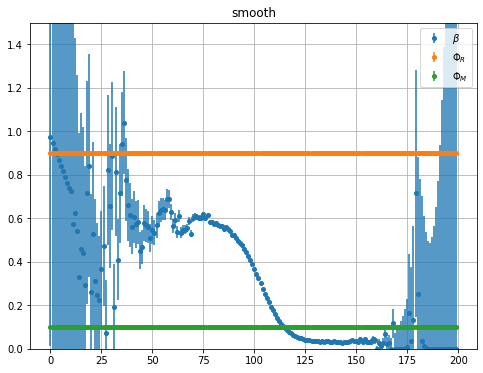

In [16]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5));

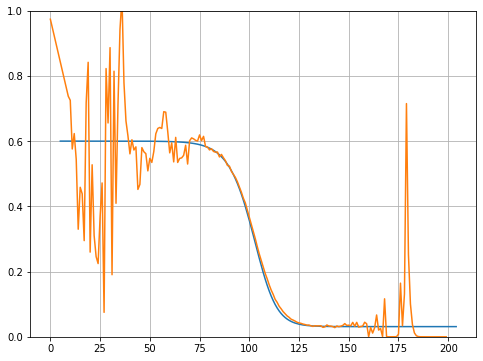

In [17]:
betas = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts + TI, R0/TR * S/N)
plt.plot(ts, betas);
plt.grid(); plt.ylim((0., 1.));

### Use death as proxy

In [18]:
times    = TI, TR, TM
q0       = 1e0 * np.array((1., 0., 0.))
dios, dms, drs = ds
ts       = np.arange(len(dms))
xss, xms = us.useir_kfs((dms, dms, dms), times, q0 = q0, scale = True)

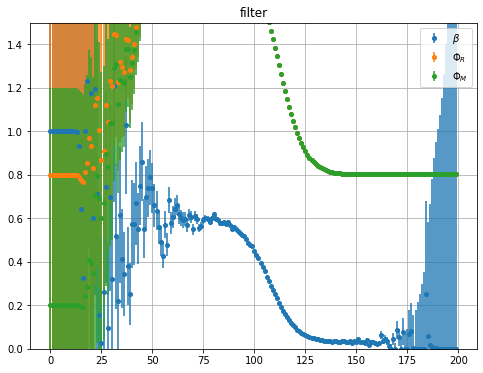

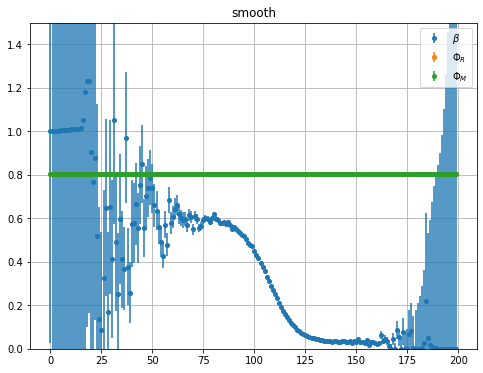

In [19]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5));

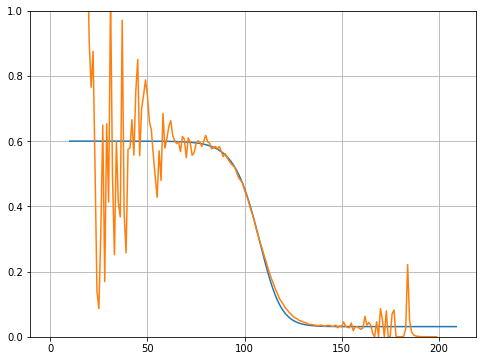

In [20]:
betas = [xi[0] for xi in xs]
plt.figure(figsize = (8, 6))
plt.plot(ts + TI + TM, R0/TR * S/N)
plt.plot(ts, betas);
plt.grid(); plt.ylim((0., 1.));

## uSEIR-quenched

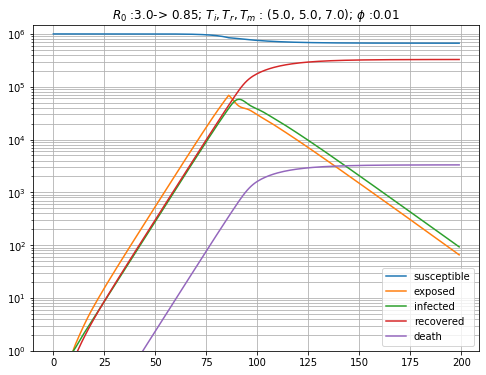

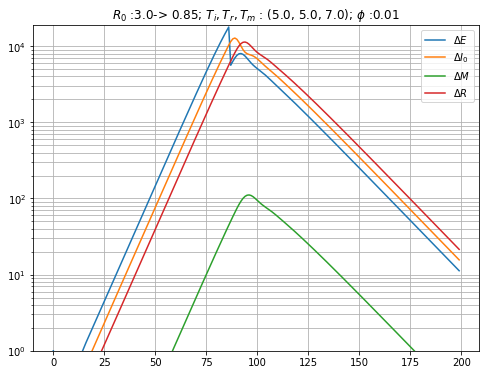

In [24]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 7.
PhiM            = 0.01
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)

S1, R1          = 0.15, 0.85
SS, DD          = us.uSEIR_Rvar(N, R0, TI, TR, TM, PhiM, S1, R1, ndays, rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

ts = np.arange(ndays)
title = r'$R_0$ :'+ str(R0)+ '-> '+str(R1)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title, yscale = 'log');

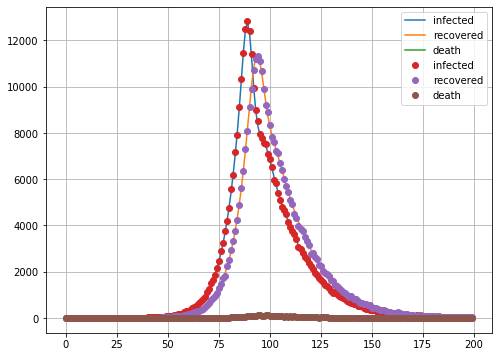

In [66]:
DS = DI0, DR, DM
ds = us.useir_rvdata(DI0, DR, DM)
us.plt_useir_rvdata(ts, DS, ds);

### KF $\beta$(t) - rate evolution

In [67]:
times    = TI, TR, TM
q0       = 1e4 * np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0, scale = False)

(0.0, 1.5)

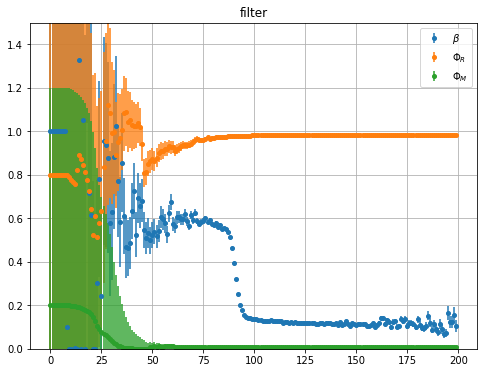

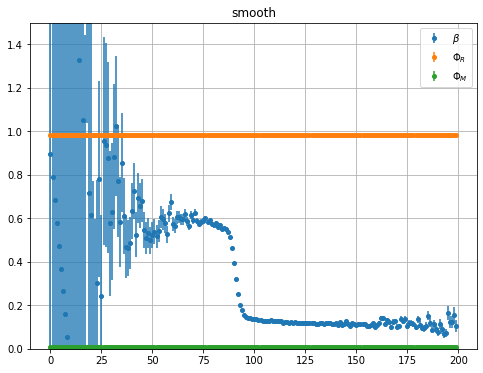

In [68]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5))

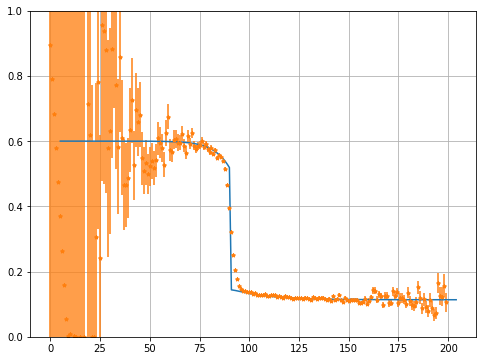

In [69]:
betas  = [xi[0] for xi in xs]
ubetas = [np.sqrt(xi[0, 0]) for xi in uxs]
plt.figure(figsize = (8, 6))

sel = S/N > 1 - S1
rr  = np.zeros(ndays)
rr[sel]  = R0/TR * S[sel] /N
rr[~sel] = R1/TR * S[~sel]/N

plt.plot(ts + TI, rr)
plt.errorbar(ts, betas, yerr = ubetas, ls = '', marker = '*', ms = 4);
plt.grid(); plt.ylim((0., 1.));

betas0, ubetas0 = betas, ubetas

### Use death as a proxy

In [70]:
times    = TI, TR, TM
q0       = 10e0 * np.array((1., 0., 0.))
dios, dms, drs = ds
ts       = np.arange(len(dms))
xss, xms = us.useir_kfs((dms, dms, dms), times, q0 = q0, scale = True)

(0.0, 1.5)

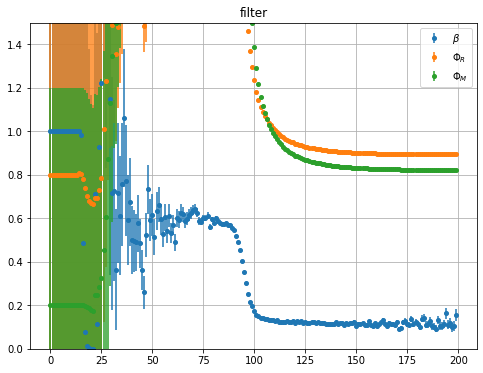

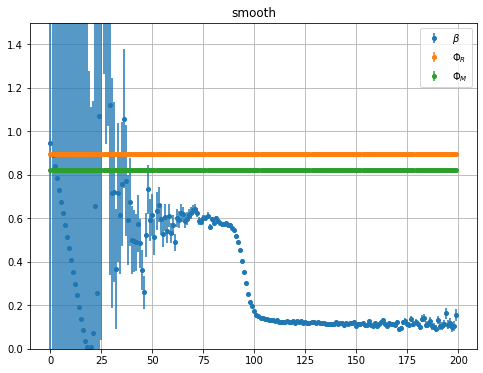

In [71]:
xm, uxm = xms
us.plot_kfs(xm, uxm)
plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
us.plot_kfs(xs, uxs)
plt.title('smooth'); plt.ylim((0., 1.5))

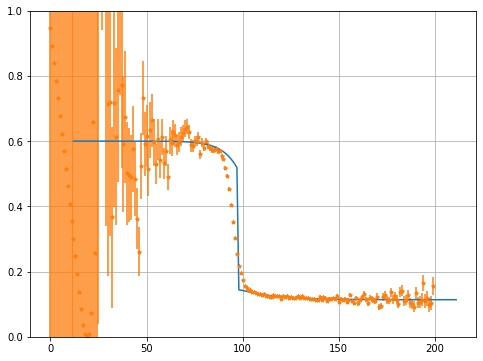

In [72]:
betas  = [xi[0] for xi in xs]
ubetas = [np.sqrt(xi[0, 0]) for xi in uxs]
plt.figure(figsize = (8, 6))

sel = S/N > 1 - S1
rr  = np.zeros(ndays)
rr[sel]  = R0/TR * S[sel] /N
rr[~sel] = R1/TR * S[~sel]/N

plt.plot(ts + TI + TM, rr)
plt.errorbar(ts, betas, yerr = ubetas, ls = '', marker = '*', ms = 4);
plt.grid(); plt.ylim((0., 1.));

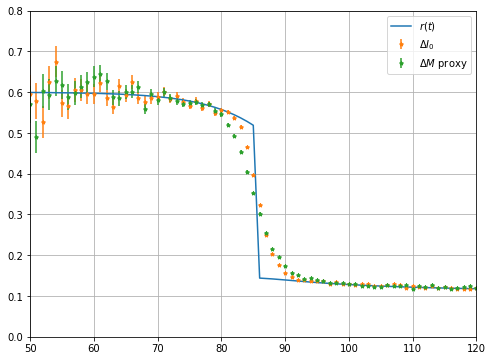

In [80]:
plt.figure(figsize = ((8, 6)))
plt.plot(ts, rr, label = r'$r(t)$')
plt.errorbar(ts - TI , betas0, yerr = ubetas0, ls = '', marker = '*', ms = 4, label = r'$\Delta I_0$');
plt.errorbar(ts - TI - TR, betas , yerr = ubetas, ls = '', marker = '*', ms = 4, label = r'$\Delta M$ proxy');
plt.grid(); plt.ylim((0., 0.8)); plt.legend(); plt.xlim((50, 120));

## Conclusions

- KF (filter + smoother) with H-matrices with prediction of new-infected, recovered and deaths works. Needs as input the times: infection, recovery, and death, and the pdf (i.e gamma)

- If the susceptibles is known (accademic) the KF returns $\beta$, there infection rate

- If the susceptibles are not know (reality) the KF returns $\beta(t)$ that is shifted by the time of infection, $T_I$.

- KF follows $\beta$(t) for uSEIR-quenched pandemia. $\beta$ follows $R(t)/T \, S/N$ with a delay $T_I + T_R$
- The step in $\beta$(t) seems to be smoothed by $T_I + T_R$.